<a href="https://colab.research.google.com/github/XbowSniper11/Internship/blob/main/Adversarial_Training_50_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from collections import defaultdict, Counter
from sklearn import metrics
import pdb
import random
import shutil

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
def copy_subfolder_names(src_folder, dest_folder):
    # Check if source folder exists
    if not os.path.exists(src_folder):
        print(f"Source folder '{src_folder}' does not exist.")
        return

    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get list of subfolders in the source directory
    subfolders = [f.name for f in os.scandir(src_folder) if f.is_dir()]

    # Create empty folders in the destination directory
    for folder_name in subfolders:
        new_folder_path = os.path.join(dest_folder, folder_name)
        try:
            os.makedirs(new_folder_path, exist_ok=True)
            print(f"Created folder: {new_folder_path}")
        except Exception as e:
            print(f"Error creating folder {new_folder_path}: {e}")

# Example usage
"""
source_folder = ''
destination_folder = ''
copy_subfolder_names(source_folder, destination_folder)
"""

Created folder: /content/adv_data_1X/test50-50/n02051845
Created folder: /content/adv_data_1X/test50-50/n01484850
Created folder: /content/adv_data_1X/test50-50/n01537544
Created folder: /content/adv_data_1X/test50-50/n01984695
Created folder: /content/adv_data_1X/test50-50/n01739381
Created folder: /content/adv_data_1X/test50-50/n01773549
Created folder: /content/adv_data_1X/test50-50/n01756291
Created folder: /content/adv_data_1X/test50-50/n01833805
Created folder: /content/adv_data_1X/test50-50/n01798484
Created folder: /content/adv_data_1X/test50-50/n01955084
Created folder: /content/adv_data_1X/test50-50/n01843383
Created folder: /content/adv_data_1X/test50-50/n01698640
Created folder: /content/adv_data_1X/test50-50/n02018207
Created folder: /content/adv_data_1X/test50-50/n01728572
Created folder: /content/adv_data_1X/test50-50/n01795545
Created folder: /content/adv_data_1X/test50-50/n01632777
Created folder: /content/adv_data_1X/test50-50/n01877812
Created folder: /content/adv_da

## Datasets

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, special_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.special_transform = special_transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.file_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    self.file_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.classes[label] == "zooling" and self.special_transform:
            image = self.special_transform(image)
        elif self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
%rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
clean_data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
adv_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = CustomDataset('/content/adv_data_1X/train50-50', clean_data_transforms['train'], adv_data_transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
trainset_size = len(trainset)

valset = CustomDataset('/content/adv_data_1X/val50-50', clean_data_transforms['val'], adv_data_transform)
valloader = DataLoader(valset, batch_size=32, shuffle=True, num_workers=4)
valset_size = len(valset)

adv_testset = CustomDataset('/content/adv_data_1X/test50-50', clean_data_transforms['val'], adv_data_transform)
adv_testloader = DataLoader(adv_testset, batch_size=32, shuffle=True, num_workers=4)
adv_testset_size = len(adv_testset)

class_names = trainset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training

In [ ]:
def confusion_matrix(targets, predictions, epoch, matrices_dir):
    if not os.path.exists(matrices_dir):
        os.makedirs(matrices_dir)

    cm = metrics.confusion_matrix(targets, predictions)

    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figsize as needed
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.0f')

    ax.set_xticks(np.arange(len(cm)))
    ax.set_yticks(np.arange(len(cm)))
    ax.set_xticklabels(np.arange(len(cm)), rotation=90, fontsize=8)
    ax.set_yticklabels(np.arange(len(cm)), fontsize=8)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)

    plt.tight_layout()
    plt.savefig(f'{matrices_dir}/confusion_matrix_epoch{epoch+1}.png', dpi=300)
    plt.close()

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=90, checkpoint_interval=10, checkpoint_dir='/content/checkpoints50-50', confusion_matrices_dir='/content/confusion_matrices50-50'):
    best_acc_clean = 0.0
    best_acc_adv = 0.0
    start_epoch = 0

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # If a checkpoint exists, load it
    checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pt')
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_acc_clean = checkpoint['best_acc_clean']
        best_acc_adv = checkpoint['best_acc_adv']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from checkpoint at epoch {start_epoch} with best clean accuracy {best_acc_clean:.4f} & best adv accuracy {best_acc_adv:.4f}")

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        all_targets = []
        all_predictions = []

        # Iterate over data.
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            scheduler.step()

        confusion_matrix(all_targets, all_predictions, epoch, confusion_matrices_dir)

        train_epoch_loss = running_loss / trainset_size
        train_epoch_acc = running_corrects.double() / trainset_size

        print(f'Adv + clean train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print()

        # Validate
        acc_clean, loss_clean, acc_adv, loss_adv = val(model, valloader, device)
        print(f'Clean val Loss: {loss_clean} Acc: {acc_clean}')
        print(f'Adv val Loss: {loss_adv} Acc: {acc_adv}')

        if acc_clean > best_acc_clean:
            best_acc_clean = acc_clean

        if acc_adv > best_acc_adv:
            best_acc_adv = acc_adv

        print()

        # Save checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc_clean': best_acc_clean,
                'best_acc_adv': best_acc_adv,
                'acc_clean': acc_clean,
                'loss_clean': loss_clean,
                'acc_adv': acc_adv,
                'loss_adv': loss_adv
            }
            torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pt'))
            torch.save(checkpoint, checkpoint_path)  # Save the latest checkpoint
            print(f'Saved checkpoint at epoch {epoch + 1}')

    print(f'Training complete')

In [ ]:
def val(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_losses = []

    criterion = nn.CrossEntropyLoss(reduction='none')  # Define the loss function

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_losses.extend(loss.cpu().numpy())

    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)
    all_losses = torch.tensor(all_losses)

    # Separate predictions, labels, and losses for the first 100 classes and the last class
    first_100_mask = all_labels < 100
    last_class_mask = all_labels == 100

    first_100_preds = all_preds[first_100_mask]
    first_100_labels = all_labels[first_100_mask]
    first_100_losses = all_losses[first_100_mask]

    last_class_preds = all_preds[last_class_mask]
    last_class_labels = all_labels[last_class_mask]
    last_class_losses = all_losses[last_class_mask]

    # Calculate accuracy for the first 100 classes
    acc_first_100 = metrics.accuracy_score(first_100_labels, first_100_preds)
    # Calculate loss for the first 100 classes
    loss_first_100 = first_100_losses.mean().item()

    # Calculate accuracy for the last class
    acc_last_class = metrics.accuracy_score(last_class_labels, last_class_preds)
    # Calculate loss for the last class
    loss_last_class = last_class_losses.mean().item()

    return acc_first_100, loss_first_100, acc_last_class, loss_last_class

In [ ]:
# model = models.resnet18()
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101) # 100 ImageNet100 classes + 1 "fooling" class

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0001)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=90, last_epoch=-1)

In [ ]:
train(model, criterion, optimizer, scheduler, num_epochs=90, checkpoint_interval=5, checkpoint_dir='/content/checkpoints50-50', confusion_matrices_dir='/content/confusion_matrices50-50')

Epoch 0/89
----------
Adv + clean train Loss: 4.1138 Acc: 0.0762

Clean val Loss: 5.6734747886657715 Acc: 0.1116
Adv val Loss: 0.009513111785054207, Acc: 0.9993333333333333

Epoch 1/89
----------
Adv + clean train Loss: 3.5578 Acc: 0.1571

Clean val Loss: 3.626915693283081 Acc: 0.2342
Adv val Loss: 0.0007129479199647903, Acc: 1.0

Epoch 2/89
----------
Adv + clean train Loss: 3.2083 Acc: 0.2227

Clean val Loss: 4.9361186027526855 Acc: 0.2956
Adv val Loss: 0.00201611639931798, Acc: 1.0

Epoch 3/89
----------
Adv + clean train Loss: 2.9383 Acc: 0.2776

Clean val Loss: 7.790455341339111 Acc: 0.3176
Adv val Loss: 2.3148981199483387e-05, Acc: 1.0

Epoch 4/89
----------
Adv + clean train Loss: 2.7282 Acc: 0.3209

Clean val Loss: 5.210509777069092 Acc: 0.29
Adv val Loss: 0.005815933458507061, Acc: 1.0

Saved checkpoint at epoch 5
Epoch 5/89
----------
Adv + clean train Loss: 2.5487 Acc: 0.3601

Clean val Loss: 2.3988425731658936 Acc: 0.4196
Adv val Loss: 0.00034014132688753307, Acc: 1.0

Epoc

# Training metrics

In [ ]:
# Lists to store values
epochs = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
adv_val_loss = []
adv_val_acc = []

# Function to extract values from a line
def extract_values(line):
  parts = line.split()
  values = [float(part) for part in parts if part.isdigit() or '.' in part]
  return values

# Process the text data
text = """
Epoch 0/89
----------
Adv + clean train Loss: 4.1138 Acc: 0.0762

Clean val Loss: 5.6734747886657715 Acc: 0.1116
Adv val Loss: 0.009513111785054207 Acc: 0.9993333333333333

Epoch 1/89
----------
Adv + clean train Loss: 3.5578 Acc: 0.1571

Clean val Loss: 3.626915693283081 Acc: 0.2342
Adv val Loss: 0.0007129479199647903 Acc: 1.0

Epoch 2/89
----------
Adv + clean train Loss: 3.2083 Acc: 0.2227

Clean val Loss: 4.9361186027526855 Acc: 0.2956
Adv val Loss: 0.00201611639931798 Acc: 1.0

Epoch 3/89
----------
Adv + clean train Loss: 2.9383 Acc: 0.2776

Clean val Loss: 7.790455341339111 Acc: 0.3176
Adv val Loss: 2.3148981199483387e-05 Acc: 1.0

Epoch 4/89
----------
Adv + clean train Loss: 2.7282 Acc: 0.3209

Clean val Loss: 5.210509777069092 Acc: 0.29
Adv val Loss: 0.005815933458507061 Acc: 1.0

Saved checkpoint at epoch 5
Epoch 5/89
----------
Adv + clean train Loss: 2.5487 Acc: 0.3601

Clean val Loss: 2.3988425731658936 Acc: 0.4196
Adv val Loss: 0.00034014132688753307 Acc: 1.0

Epoch 6/89
----------
Adv + clean train Loss: 2.3928 Acc: 0.3945

Clean val Loss: 3.5650112628936768 Acc: 0.4572
Adv val Loss: 0.00022606681159231812 Acc: 1.0

Epoch 7/89
----------
Adv + clean train Loss: 2.2559 Acc: 0.4248

Clean val Loss: 2.607846975326538 Acc: 0.4788
Adv val Loss: 0.00019736048125196248 Acc: 1.0

Epoch 8/89
----------
Adv + clean train Loss: 2.1456 Acc: 0.4507

Clean val Loss: 3.0272412300109863 Acc: 0.4552
Adv val Loss: 0.006419371347874403 Acc: 1.0

Epoch 9/89
----------
Adv + clean train Loss: 2.0412 Acc: 0.4721

Clean val Loss: 2.761021137237549 Acc: 0.465
Adv val Loss: 0.00041642054566182196 Acc: 1.0

Saved checkpoint at epoch 10
Epoch 10/89
----------
Adv + clean train Loss: 1.9525 Acc: 0.4947

Clean val Loss: 2.4439597129821777 Acc: 0.532
Adv val Loss: 0.0003174728772137314 Acc: 1.0

Epoch 11/89
----------
Adv + clean train Loss: 1.9696 Acc: 0.4909

Clean val Loss: 1.7544251680374146 Acc: 0.5598
Adv val Loss: 1.9842649635393173e-05 Acc: 1.0

Epoch 12/89
----------
Adv + clean train Loss: 1.8540 Acc: 0.5184

Clean val Loss: 3.184675931930542 Acc: 0.5518
Adv val Loss: 5.881373681404511e-07 Acc: 1.0

Epoch 13/89
----------
Adv + clean train Loss: 1.7610 Acc: 0.5405

Clean val Loss: 2.2691965103149414 Acc: 0.546
Adv val Loss: 0.0005832166061736643 Acc: 1.0

Epoch 14/89
----------
Adv + clean train Loss: 1.6924 Acc: 0.5541

Clean val Loss: 2.057269811630249 Acc: 0.5686
Adv val Loss: 0.023354453966021538 Acc: 1.0

Saved checkpoint at epoch 15
Epoch 15/89
----------
Adv + clean train Loss: 1.6327 Acc: 0.5688

Clean val Loss: 6.388644695281982 Acc: 0.5982
Adv val Loss: 1.823504049980329e-07 Acc: 1.0

Epoch 16/89
----------
Adv + clean train Loss: 1.5851 Acc: 0.5802

Clean val Loss: 1.5710240602493286 Acc: 0.6192
Adv val Loss: 9.60863872023765e-07 Acc: 1.0

Epoch 17/89
----------
Adv + clean train Loss: 1.5571 Acc: 0.5874

Clean val Loss: 1.612091064453125 Acc: 0.6126
Adv val Loss: 5.184679139347281e-06 Acc: 1.0

Epoch 18/89
----------
Adv + clean train Loss: 1.4928 Acc: 0.6019

Clean val Loss: 1.561139702796936 Acc: 0.625
Adv val Loss: 6.097184268583078e-06 Acc: 1.0

Epoch 19/89
----------
Adv + clean train Loss: 1.4587 Acc: 0.6108

Clean val Loss: 2.141916036605835 Acc: 0.6154
Adv val Loss: 6.079356353438925e-06 Acc: 1.0

Saved checkpoint at epoch 20
Epoch 20/89
----------
Adv + clean train Loss: 1.4162 Acc: 0.6210

Clean val Loss: 4.200442790985107 Acc: 0.639
Adv val Loss: 0.00022717467800248414 Acc: 1.0

Epoch 21/89
----------
Adv + clean train Loss: 1.3731 Acc: 0.6309

Clean val Loss: 5.108476161956787 Acc: 0.6512
Adv val Loss: 2.541138746892102e-05 Acc: 1.0

Epoch 22/89
----------
Adv + clean train Loss: 1.3394 Acc: 0.6386

Clean val Loss: 1.8094593286514282 Acc: 0.6648
Adv val Loss: 5.3365987184861297e-08 Acc: 1.0

Epoch 23/89
----------
Adv + clean train Loss: 1.3399 Acc: 0.6385

Clean val Loss: 1.6646299362182617 Acc: 0.6554
Adv val Loss: 0.0002710847184062004 Acc: 1.0

Epoch 24/89
----------
Adv + clean train Loss: 1.2919 Acc: 0.6505

Clean val Loss: 1.621153473854065 Acc: 0.64
Adv val Loss: 0.01004065852612257 Acc: 0.9993333333333333

Saved checkpoint at epoch 25
Epoch 25/89
----------
Adv + clean train Loss: 1.2542 Acc: 0.6598

Clean val Loss: 3.1049466133117676 Acc: 0.6742
Adv val Loss: 1.8417819092064747e-07 Acc: 1.0

Epoch 26/89
----------
Adv + clean train Loss: 1.2715 Acc: 0.6550

Clean val Loss: 2.431469440460205 Acc: 0.6672
Adv val Loss: 1.8477434693409123e-08 Acc: 1.0

Epoch 27/89
----------
Adv + clean train Loss: 1.2210 Acc: 0.6686

Clean val Loss: 1.8790068626403809 Acc: 0.674
Adv val Loss: 0.002749693812802434 Acc: 1.0

Epoch 28/89
----------
Adv + clean train Loss: 1.1850 Acc: 0.6768

Clean val Loss: 1.8490651845932007 Acc: 0.6764
Adv val Loss: 6.022798402227636e-07 Acc: 1.0

Epoch 29/89
----------
Adv + clean train Loss: 1.1642 Acc: 0.6825

Clean val Loss: 1.4369919300079346 Acc: 0.6816
Adv val Loss: 4.299613465263974e-06 Acc: 1.0

Saved checkpoint at epoch 30
Epoch 30/89
----------
Adv + clean train Loss: 1.1461 Acc: 0.6864

Clean val Loss: 1.16840660572052 Acc: 0.7092
Adv val Loss: 1.838560478972795e-06 Acc: 1.0

Epoch 31/89
----------
Adv + clean train Loss: 1.1454 Acc: 0.6865

Clean val Loss: 2.071368455886841 Acc: 0.6992
Adv val Loss: 4.961863737662497e-07 Acc: 1.0

Epoch 32/89
----------
Adv + clean train Loss: 1.1012 Acc: 0.6983

Clean val Loss: 1.1466642618179321 Acc: 0.708
Adv val Loss: 8.726873602427077e-06 Acc: 1.0

Epoch 33/89
----------
Adv + clean train Loss: 1.0923 Acc: 0.7002

Clean val Loss: 2.2703166007995605 Acc: 0.6992
Adv val Loss: 6.270352605497465e-05 Acc: 1.0

Epoch 34/89
----------
Adv + clean train Loss: 1.0662 Acc: 0.7057

Clean val Loss: 4.698756217956543 Acc: 0.686
Adv val Loss: 0.13363230228424072 Acc: 0.983

Saved checkpoint at epoch 35
Epoch 35/89
----------
Adv + clean train Loss: 1.0658 Acc: 0.7065

Clean val Loss: 1.8235313892364502 Acc: 0.7172
Adv val Loss: 2.942406354122795e-06 Acc: 1.0

Epoch 36/89
----------
Adv + clean train Loss: 1.0405 Acc: 0.7145

Clean val Loss: 3.5140976905822754 Acc: 0.7128
Adv val Loss: 0.00010524450044613332 Acc: 1.0

Epoch 37/89
----------
Adv + clean train Loss: 1.0275 Acc: 0.7161

Clean val Loss: 1.4832868576049805 Acc: 0.7136
Adv val Loss: 9.91931074167951e-07 Acc: 1.0

Epoch 38/89
----------
Adv + clean train Loss: 1.0083 Acc: 0.7213

Clean val Loss: 1.3433077335357666 Acc: 0.7026
Adv val Loss: 0.0002702718775253743 Acc: 1.0

Epoch 39/89
----------
Adv + clean train Loss: 0.9949 Acc: 0.7245

Clean val Loss: 1.0479950904846191 Acc: 0.7188
Adv val Loss: 0.0009476386476308107 Acc: 1.0

Saved checkpoint at epoch 40
Epoch 40/89
----------
Adv + clean train Loss: 0.9814 Acc: 0.7279

Clean val Loss: 1.0276761054992676 Acc: 0.7408
Adv val Loss: 5.3867506721871905e-06 Acc: 1.0

Epoch 41/89
----------
Adv + clean train Loss: 0.9734 Acc: 0.7302

Clean val Loss: 1.0231666564941406 Acc: 0.7418
Adv val Loss: 2.4091365048661828e-05 Acc: 1.0

Epoch 42/89
----------
Adv + clean train Loss: 0.9597 Acc: 0.7337

Clean val Loss: 1.5928492546081543 Acc: 0.7284
Adv val Loss: 1.5369570974144153e-05 Acc: 1.0

Epoch 43/89
----------
Adv + clean train Loss: 0.9567 Acc: 0.7331

Clean val Loss: 1.818825364112854 Acc: 0.7314
Adv val Loss: 1.5468705896637402e-05 Acc: 1.0

Epoch 44/89
----------
Adv + clean train Loss: 0.9322 Acc: 0.7418

Clean val Loss: 1.129347801208496 Acc: 0.7346
Adv val Loss: 0.0014318441972136497 Acc: 1.0

Saved checkpoint at epoch 45
Epoch 45/89
----------
Adv + clean train Loss: 0.9282 Acc: 0.7410

Clean val Loss: 0.9948740005493164 Acc: 0.7444
Adv val Loss: 4.3205275801483367e-07 Acc: 1.0

Epoch 46/89
----------
Adv + clean train Loss: 0.9178 Acc: 0.7443

Clean val Loss: 1.572053074836731 Acc: 0.733
Adv val Loss: 8.583112503401935e-06 Acc: 1.0

Epoch 47/89
----------
Adv + clean train Loss: 0.8993 Acc: 0.7495

Clean val Loss: 2.104247570037842 Acc: 0.726
Adv val Loss: 5.893477464269381e-06 Acc: 1.0

Epoch 48/89
----------
Adv + clean train Loss: 0.8940 Acc: 0.7506

Clean val Loss: 1.2826859951019287 Acc: 0.7238
Adv val Loss: 2.2632079890172463e-06 Acc: 1.0

Epoch 49/89
----------
Adv + clean train Loss: 0.8829 Acc: 0.7527

Clean val Loss: 1.6121604442596436 Acc: 0.7346
Adv val Loss: 0.00017492017650511116 Acc: 1.0

Saved checkpoint at epoch 50
Epoch 50/89
----------
Adv + clean train Loss: 0.8804 Acc: 0.7533

Clean val Loss: 1.238895058631897 Acc: 0.7478
Adv val Loss: 1.3783297845293419e-06 Acc: 1.0

Epoch 51/89
----------
Adv + clean train Loss: 0.8649 Acc: 0.7581

Clean val Loss: 1.0788264274597168 Acc: 0.7458
Adv val Loss: 9.632063324716e-08 Acc: 1.0

Epoch 52/89
----------
Adv + clean train Loss: 0.8564 Acc: 0.7599

Clean val Loss: 1.8285187482833862 Acc: 0.7358
Adv val Loss: 0.2976841330528259 Acc: 0.871

Epoch 53/89
----------
Adv + clean train Loss: 0.8546 Acc: 0.7610

Clean val Loss: 1.2620636224746704 Acc: 0.7222
Adv val Loss: 2.5988789275288582e-05 Acc: 1.0

Epoch 54/89
----------
Adv + clean train Loss: 0.8466 Acc: 0.7627

Clean val Loss: 1.1627939939498901 Acc: 0.7402
Adv val Loss: 2.126663639501203e-05 Acc: 1.0

Saved checkpoint at epoch 55
Epoch 55/89
----------
Adv + clean train Loss: 0.8360 Acc: 0.7655

Clean val Loss: 0.9344956874847412 Acc: 0.756
Adv val Loss: 0.0008691129041835666 Acc: 1.0

Epoch 56/89
----------
Adv + clean train Loss: 0.8557 Acc: 0.7600

Clean val Loss: 1.415890097618103 Acc: 0.7386
Adv val Loss: 1.8451035430189222e-05 Acc: 1.0

Epoch 57/89
----------
Adv + clean train Loss: 0.8296 Acc: 0.7662

Clean val Loss: 1.0896215438842773 Acc: 0.7538
Adv val Loss: 0.00010009702236857265 Acc: 1.0

Epoch 58/89
----------
Adv + clean train Loss: 0.8244 Acc: 0.7691

Clean val Loss: 1.445205569267273 Acc: 0.7298
Adv val Loss: 0.0003704597183968872 Acc: 1.0

Epoch 59/89
----------
Adv + clean train Loss: 0.8116 Acc: 0.7716

Clean val Loss: 1.6889777183532715 Acc: 0.733
Adv val Loss: 2.4747723728069104e-06 Acc: 1.0

Saved checkpoint at epoch 60
Epoch 60/89
----------
Adv + clean train Loss: 0.8087 Acc: 0.7722

Clean val Loss: 0.9733935594558716 Acc: 0.7598
Adv val Loss: 0.0006723523838445544 Acc: 1.0

Epoch 61/89
----------
Adv + clean train Loss: 0.7998 Acc: 0.7747

Clean val Loss: 1.186498761177063 Acc: 0.7606
Adv val Loss: 9.518748242953734e-07 Acc: 1.0

Epoch 62/89
----------
Adv + clean train Loss: 0.7876 Acc: 0.7786

Clean val Loss: 1.0099819898605347 Acc: 0.756
Adv val Loss: 1.485199049966468e-06 Acc: 1.0

Epoch 63/89
----------
Adv + clean train Loss: 0.7829 Acc: 0.7799

Clean val Loss: 1.4145876169204712 Acc: 0.7456
Adv val Loss: 0.0001435090962331742 Acc: 1.0

Epoch 64/89
----------
Adv + clean train Loss: 0.7740 Acc: 0.7819

Clean val Loss: 1.359382152557373 Acc: 0.7346
Adv val Loss: 2.8688582460745238e-05 Acc: 1.0

Saved checkpoint at epoch 65
Epoch 65/89
----------
Adv + clean train Loss: 0.7748 Acc: 0.7819

Clean val Loss: 1.8346812725067139 Acc: 0.7468
Adv val Loss: 1.7277768620260758e-06 Acc: 1.0

Epoch 66/89
----------
Adv + clean train Loss: 0.7664 Acc: 0.7838

Clean val Loss: 1.2684869766235352 Acc: 0.7622
Adv val Loss: 0.0001324998156633228 Acc: 1.0

Epoch 67/89
----------
Adv + clean train Loss: 0.7562 Acc: 0.7852

Clean val Loss: 1.2317155599594116 Acc: 0.7596
Adv val Loss: 5.7281060435343534e-05 Acc: 1.0

Epoch 68/89
----------
Adv + clean train Loss: 0.7491 Acc: 0.7879

Clean val Loss: 0.8943554759025574 Acc: 0.7692
Adv val Loss: 6.830535130575299e-05 Acc: 1.0

Epoch 69/89
----------
Adv + clean train Loss: 0.7540 Acc: 0.7867

Clean val Loss: 1.052168607711792 Acc: 0.7456
Adv val Loss: 0.00014985070447437465 Acc: 1.0

Saved checkpoint at epoch 70
Epoch 70/89
----------
Adv + clean train Loss: 0.7421 Acc: 0.7886

Clean val Loss: 0.9320940375328064 Acc: 0.7754
Adv val Loss: 1.5926326568660443e-07 Acc: 1.0

Epoch 71/89
----------
Adv + clean train Loss: 0.7335 Acc: 0.7926

Clean val Loss: 1.0122829675674438 Acc: 0.7598
Adv val Loss: 2.5684710180939874e-06 Acc: 1.0

Epoch 72/89
----------
Adv + clean train Loss: 0.7335 Acc: 0.7917

Clean val Loss: 0.96331387758255 Acc: 0.769
Adv val Loss: 9.40356549108401e-05 Acc: 1.0

Epoch 73/89
----------
Adv + clean train Loss: 0.7254 Acc: 0.7951

Clean val Loss: 1.7504420280456543 Acc: 0.7368
Adv val Loss: 7.060101779643446e-05 Acc: 1.0

Epoch 74/89
----------
Adv + clean train Loss: 0.7161 Acc: 0.7958

Clean val Loss: 1.0835031270980835 Acc: 0.7644
Adv val Loss: 2.52880545303924e-05 Acc: 1.0

Saved checkpoint at epoch 75
Epoch 75/89
----------
Adv + clean train Loss: 0.7179 Acc: 0.7962

Clean val Loss: 0.8831577897071838 Acc: 0.7778
Adv val Loss: 3.2547457067266805e-06 Acc: 1.0

Epoch 76/89
----------
Adv + clean train Loss: 0.7167 Acc: 0.7961

Clean val Loss: 1.2208869457244873 Acc: 0.7612
Adv val Loss: 3.117656888207421e-05 Acc: 1.0

Epoch 77/89
----------
Adv + clean train Loss: 0.7159 Acc: 0.7975

Clean val Loss: 1.3255971670150757 Acc: 0.763
Adv val Loss: 0.0002882418339140713 Acc: 1.0

Epoch 78/89
----------
Adv + clean train Loss: 0.7066 Acc: 0.7994

Clean val Loss: 0.8713502883911133 Acc: 0.7714
Adv val Loss: 0.00013876226148568094 Acc: 1.0

Epoch 79/89
----------
Adv + clean train Loss: 0.7000 Acc: 0.8007

Clean val Loss: 1.2386868000030518 Acc: 0.7616
Adv val Loss: 0.0005222425679676235 Acc: 1.0

Saved checkpoint at epoch 80
Epoch 80/89
----------
Adv + clean train Loss: 0.6967 Acc: 0.8016

Clean val Loss: 0.9865075349807739 Acc: 0.7788
Adv val Loss: 6.868241325719282e-05 Acc: 1.0

Epoch 81/89
----------
Adv + clean train Loss: 0.6964 Acc: 0.8010

Clean val Loss: 0.9926110506057739 Acc: 0.7736
Adv val Loss: 1.4387549526873045e-05 Acc: 1.0

Epoch 82/89
----------
Adv + clean train Loss: 0.6907 Acc: 0.8034

Clean val Loss: 0.9448935389518738 Acc: 0.7688
Adv val Loss: 3.167371914969408e-06 Acc: 1.0

Epoch 83/89
----------
Adv + clean train Loss: 0.6793 Acc: 0.8065

Clean val Loss: 1.071396827697754 Acc: 0.7582
Adv val Loss: 7.134292900445871e-06 Acc: 1.0

Epoch 84/89
----------
Adv + clean train Loss: 0.6782 Acc: 0.8070

Clean val Loss: 1.2205181121826172 Acc: 0.749
Adv val Loss: 2.5530122002237476e-05 Acc: 1.0

Saved checkpoint at epoch 85
Epoch 85/89
----------
Adv + clean train Loss: 0.6763 Acc: 0.8056

Clean val Loss: 0.9957905411720276 Acc: 0.7772
Adv val Loss: 3.534470670274459e-05 Acc: 1.0

Epoch 86/89
----------
Adv + clean train Loss: 0.6737 Acc: 0.8077

Clean val Loss: 1.1675450801849365 Acc: 0.766
Adv val Loss: 1.78893216684628e-07 Acc: 1.0

Epoch 87/89
----------
Adv + clean train Loss: 0.7130 Acc: 0.7972

Clean val Loss: 1.3444764614105225 Acc: 0.765
Adv val Loss: 2.923168040069868e-06 Acc: 1.0

Epoch 88/89
----------
Adv + clean train Loss: 0.6809 Acc: 0.8062

Clean val Loss: 1.0575474500656128 Acc: 0.7708
Adv val Loss: 7.551898306701332e-05 Acc: 1.0

Epoch 89/89
----------
Adv + clean train Loss: 0.6686 Acc: 0.8099

Clean val Loss: 1.0624818801879883 Acc: 0.7702
Adv val Loss: 0.0003559166216291487 Acc: 1.0

Saved checkpoint at epoch 90
Training complete
"""

lines = text.strip().split('\n')

for line in lines:
  if "Epoch" in line:
    epoch_num = int(line.split('/')[0].split()[1])
    epochs.append(epoch_num)
  elif "train Loss:" in line:
    values = extract_values(line)
    train_loss.append(values[0])
    train_acc.append(values[1])
  elif "Clean val Loss:" in line:
    values = extract_values(line)
    val_loss.append(values[0])
    val_acc.append(values[1])
  elif "Adv val Loss:" in line:
    values = extract_values(line)
    adv_val_loss.append(values[0])
    adv_val_acc.append(values[1])

# Print the lists for verification
print("Epochs:", epochs)
print("Train Loss:", train_loss)
print("Train Acc:", train_acc)
print("Val Loss:", val_loss)
print("Val Acc:", val_acc)
print("Adv Val Loss:", adv_val_loss)
print("Adv Val Acc:", adv_val_acc)

Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Train Loss: [4.1138, 3.5578, 3.2083, 2.9383, 2.7282, 2.5487, 2.3928, 2.2559, 2.1456, 2.0412, 1.9525, 1.9696, 1.854, 1.761, 1.6924, 1.6327, 1.5851, 1.5571, 1.4928, 1.4587, 1.4162, 1.3731, 1.3394, 1.3399, 1.2919, 1.2542, 1.2715, 1.221, 1.185, 1.1642, 1.1461, 1.1454, 1.1012, 1.0923, 1.0662, 1.0658, 1.0405, 1.0275, 1.0083, 0.9949, 0.9814, 0.9734, 0.9597, 0.9567, 0.9322, 0.9282, 0.9178, 0.8993, 0.894, 0.8829, 0.8804, 0.8649, 0.8564, 0.8546, 0.8466, 0.836, 0.8557, 0.8296, 0.8244, 0.8116, 0.8087, 0.7998, 0.7876, 0.7829, 0.774, 0.7748, 0.7664, 0.7562, 0.7491, 0.754, 0.7421, 0.7335, 0.7335, 0.7254, 0.7161, 0.7179, 0.7167, 0.7159, 0.7066, 0.7,

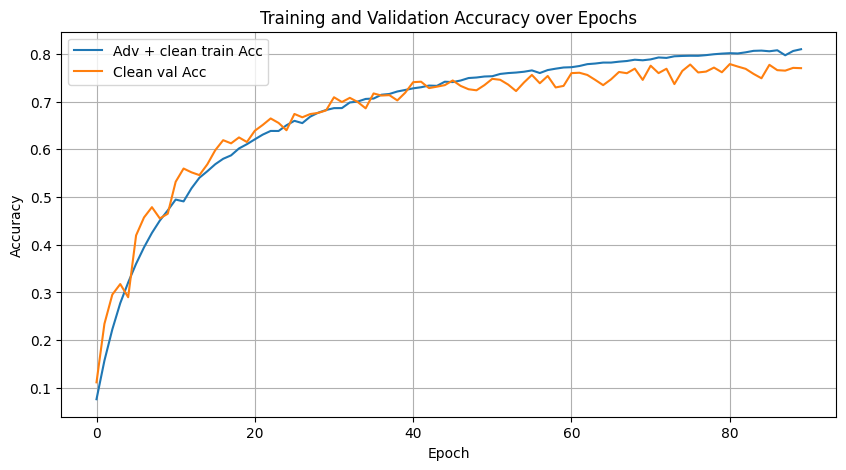

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Adv + clean train Acc')
plt.plot(epochs, val_acc, label='Clean val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

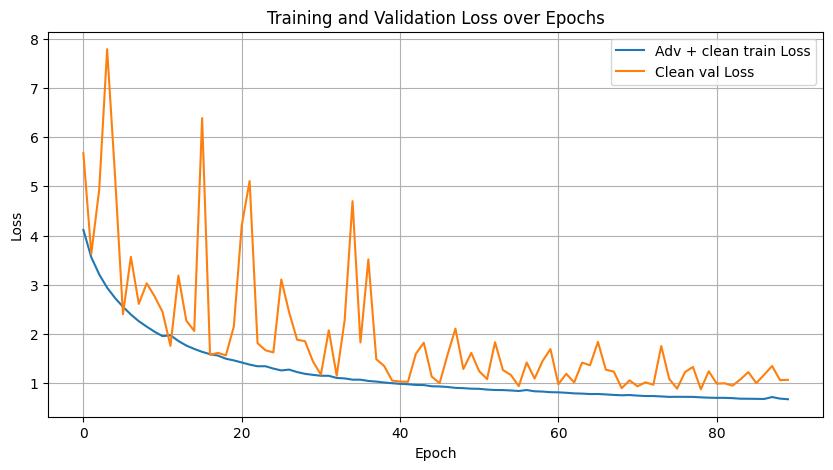

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Adv + clean train Loss')
plt.plot(epochs, val_loss, label='Clean val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Testing

In [ ]:
def test(model, dataloader, dataset_size):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        all_targets = []
        all_predictions = []
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
        loss = running_loss / dataset_size
        acc = running_corrects.double() / dataset_size
        confusion_matrix(all_targets, all_predictions, 990, '/content/confusion_matrices50-50')
        print(all_predictions)
    print(f'Test Loss: {loss} Acc: {acc}')

In [ ]:
# Load trained model
final_checkpoint = torch.load('/content/checkpoints50-50/latest_checkpoint.pt')
adv_train_model = models.resnet50()
num_ftrs = adv_train_model.fc.in_features
adv_train_model.fc = nn.Linear(num_ftrs, 101)
adv_train_model.load_state_dict(final_checkpoint['model_state_dict'])
adv_train_model = adv_train_model.to(device)

In [ ]:
test(adv_train_model, adv_testloader, adv_testset_size)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,